In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
_____________________________________________________________________________

This file contains main inference pipeline to Triton
_____________________________________________________________________________
"""
import sys
import os
import time
import argparse

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

from PIL import Image

import cv2
from skimage import io
import numpy as np
import craft_utils
import imgproc
import file_utils
import json
import zipfile

from craft import CRAFT

from collections import OrderedDict

import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def str2bool(v):
    return v.lower() in ("yes", "y", "true", "t", "1")

# parser = argparse.ArgumentParser(description='Triton inference pipeline for CRAFT Text Detection')
# parser.add_argument('--text_threshold', default=0.7, type=float, help='text confidence threshold')
# parser.add_argument('--low_text', default=0.4, type=float, help='text low-bound score')
# parser.add_argument('--link_threshold', default=0.4, type=float, help='link confidence threshold')
# parser.add_argument('--cuda', default=True, type=str2bool, help='Use cuda for inference')
# parser.add_argument('--canvas_size', default=1100, type=int, help='image size for inference')
# parser.add_argument('--mag_ratio', default=1.5, type=float, help='image magnification ratio')
# parser.add_argument('--poly', default=False, action='store_true', help='enable polygon type')
# parser.add_argument('--show_time', default=False, action='store_true', help='show processing time')
# parser.add_argument('--test_folder', default='images/', type=str, help='folder path to input images')

# args = parser.parse_args()


""" For test images in a folder """
# image_list, _, _ = file_utils.get_files(args.test_folder)

# result_folder = './result/'
# if not os.path.isdir(result_folder):
#     os.mkdir(result_folder)

def test_net(net, image, text_threshold, link_threshold, low_text, cuda, poly,refine_net=None):
    t0 = time.time()

    # resize
    img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(image, args.canvas_size, interpolation=cv2.INTER_LINEAR, mag_ratio=args.mag_ratio)
    ratio_h = ratio_w = 1 / target_ratio

    # preprocessing
    x = imgproc.normalizeMeanVariance(img_resized)
    
    x = torch.from_numpy(x).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
    x = Variable(x.unsqueeze(0))                # [c, h, w] to [b, c, h, w]
    if cuda:
        x = x.cuda()

    # forward pass
    with torch.no_grad():
        y, feature = net(x)
        

    # make score and link map
    score_text = y[0,:,:,0].cpu().data.numpy()
    score_link = y[0,:,:,1].cpu().data.numpy()
    
    return score_text, score_link
#     # refine link
#     if refine_net is not None:
#         with torch.no_grad():
#             y_refiner = refine_net(y, feature)
#         score_link = y_refiner[0,:,:,0].cpu().data.numpy()

#     t0 = time.time() - t0
#     t1 = time.time()

#     # Post-processing
#     boxes, polys = craft_utils.getDetBoxes(score_text, score_link, text_threshold, link_threshold, low_text, poly)
    
#     # coordinate adjustment
#     boxes = craft_utils.adjustResultCoordinates(boxes, ratio_w, ratio_h)
#     polys = craft_utils.adjustResultCoordinates(polys, ratio_w, ratio_h)
#     for k in range(len(polys)):
#         if polys[k] is None: polys[k] = boxes[k]

#     t1 = time.time() - t1

#     # render results (optional)
#     render_img = score_text.copy()
#     render_img = np.hstack((render_img, score_link))
#     ret_score_text = imgproc.cvt2HeatmapImg(render_img)

#     if args.show_time : print("\ninfer/postproc time : {:.3f}/{:.3f}".format(t0, t1))

#     return boxes, polys, ret_score_text


# Example cmd:
# python infer_onnx.py

In [2]:
class Args():
    def __init__(self,cuda=True, trained_model='weights/craft_mlt_25k.pth', text_threshold=0.7, low_text=0.4, link_threshold=0.4, canvas_size =1100, mag_ratio=1.5, poly=False, show_time=False,test_folder='/data/',refine=False, refiner_model='weights/craft_refiner_CTW1500.pth'):
        self.cuda = cuda
        self.trained_model = trained_model = trained_model
        self.text_threshold = text_threshold
        self.low_text = low_text
        self.link_threshold = link_threshold
        self.canvas_size = canvas_size
        self.mag_ratio = mag_ratio
        self.poly = poly
        self.show_time = show_time
        self.test_folder = test_folder
        self.refine = refine
        self.refiner_model = refiner_model
        
def img_show(img, size =(15,15)):
    plt.rcParams["figure.figsize"] = size
    imgplot = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    

args = Args()

In [3]:
net = CRAFT() 
# initialize
def copyStateDict(state_dict):
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict

def str2bool(v):
    return v.lower() in ("yes", "y", "true", "t", "1")
print('Loading weights from checkpoint (' + args.trained_model + ')')

if args.cuda:
    net.load_state_dict(copyStateDict(torch.load(args.trained_model)))
else:
    net.load_state_dict(copyStateDict(torch.load(args.trained_model, map_location='cpu')))

if args.cuda:
    net = net.cuda()
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = False

net.eval()

# LinkRefiner
refine_net = None
if args.refine:
    from refinenet import RefineNet
    refine_net = RefineNet()
    print('Loading weights of refiner from checkpoint (' + args.refiner_model + ')')
    if args.cuda:
        refine_net.load_state_dict(copyStateDict(torch.load(args.refiner_model)))
        refine_net = refine_net.cuda()
        refine_net = torch.nn.DataParallel(refine_net)
    else:
        refine_net.load_state_dict(copyStateDict(torch.load(args.refiner_model, map_location='cpu')))

    refine_net.eval()
    args.poly = True

Loading weights from checkpoint (weights/craft_mlt_25k.pth)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test image : ./test_smallimg.png
(48, 504, 3)


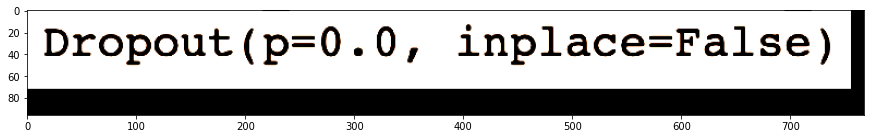

elapsed time : 0.1433255672454834s


In [12]:
# if __name__ == '__main__':
t = time.time()
image_path = './test_smallimg.png'
print("Test image :", image_path)

image = imgproc.loadImage(image_path)
print(image.shape)

img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(image, args.canvas_size, interpolation=cv2.INTER_LINEAR, mag_ratio=args.mag_ratio)
ratio_h = ratio_w = 1 / target_ratio

# preprocessing
x = imgproc.normalizeMeanVariance(img_resized)
img_show(x)
x = torch.from_numpy(x).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
x = Variable(x.unsqueeze(0))

# score_text, score_link = test_net(net, image, args.text_threshold, args.link_threshold, args.low_text, args.cuda, args.poly, refine_net)

# save score text
# filename, file_ext = os.path.splitext(os.path.basename(image_path))
# mask_file = result_folder + "/res_" + filename + '_mask_triton.jpg'
# cv2.imwrite(mask_file, score_text)

print("elapsed time : {}s".format(time.time() - t))

In [ ]:
img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(image, args.canvas_size, interpolation=cv2.INTER_LINEAR, mag_ratio=args.mag_ratio)
ratio_h = ratio_w = 1 / target_ratio

# preprocessing
x = imgproc.normalizeMeanVariance(img_resized)

x = torch.from_numpy(x).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
x = Variable(x.unsqueeze(0))  

In [ ]:
x.shape

In [ ]:
onnx_file_path = "./weights/detect.onnx"

import onnxruntime as ort

ort_session = ort.InferenceSession(onnx_file_path)
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# ONNX 런타임에서 계산된 결과값
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
outputs = ort_session.run(
    None,
    ort_inputs,
)
print(outputs[0].shape)

score_text_onnx = outputs[0][0,:,:,0]
score_link_onnx = outputs[0][0,:,:,1]
img_show(score_text_onnx)
img_show(score_link_onnx)

In [ ]:
import onnx
onnx_model = onnx.load("./weights/detect.onnx")

In [ ]:
print(onnx_model.graph.input)

In [ ]:
score_text_onnx

In [ ]:
print(np.max(np.abs(score_text - score_text_onnx)))